In [11]:
%matplotlib widget
import argparse
import gc
import random
import torch
from PIL import Image
from torchvision.transforms import PILToTensor
from src.models.dift_sd import SDFeaturizer

torch.cuda.set_device(0)

In [12]:
dift = SDFeaturizer()

In [7]:
#[1, C, H, W] or [C, H, W]
dummy_input = torch.randn(1, 3, 400, 400)
if 0: # export to onnx
    onnx_path = 'dift.onnx'
    torch.onnx.export(dift,
                        dummy_input,
                        onnx_path, 
                        opset_version=15,
                        verbose=True)
if 1: # export to torchscript
    torchscript_path = 'unet.pt'
    torch.jit.save(dift, torchscript_path)

AttributeError: 'SDFeaturizer' object has no attribute 'unet'

In [3]:
# you can choose visualize cat or guitar
category = 'pig' # random.choice(['cat', 'guitar'])

print(f"let's visualize semantic correspondence on {category}")

if category == 'cat':
    filelist = ['./assets/cat.png', './assets/target_cat.png']
elif category == 'guitar':
    filelist = ['./assets/guitar.png', './assets/target_guitar.png']
elif category == 'nozzle':
    filelist = ['./assets/03-03-23.jpg', './assets/03-05-23_1.jpg']
elif category == 'pig':
    filelist = ['./assets/tenderloin1.png', './assets/tenderloin2.png']
    
prompt = f'a photo of a scene'
#prompt = f'a photo of a {category}'

let's visualize semantic correspondence on nozzle


In [9]:
with torch.no_grad():
    torch.cuda.empty_cache()

ft = []
imglist = []

# decrease these two if you don't have enough RAM or GPU memory
img_size = 768
ensemble_size = 8

for filename in filelist:
    img = Image.open(filename).convert('RGB')
    img = img.resize((img_size, img_size))
    imglist.append(img)
    img_tensor = (PILToTensor()(img) / 255.0 - 0.5) * 2
    ft.append(dift.forward(img_tensor,
                           prompt=prompt,
                           ensemble_size=ensemble_size))
ft = torch.cat(ft, dim=0)

gc.collect()
torch.cuda.empty_cache()

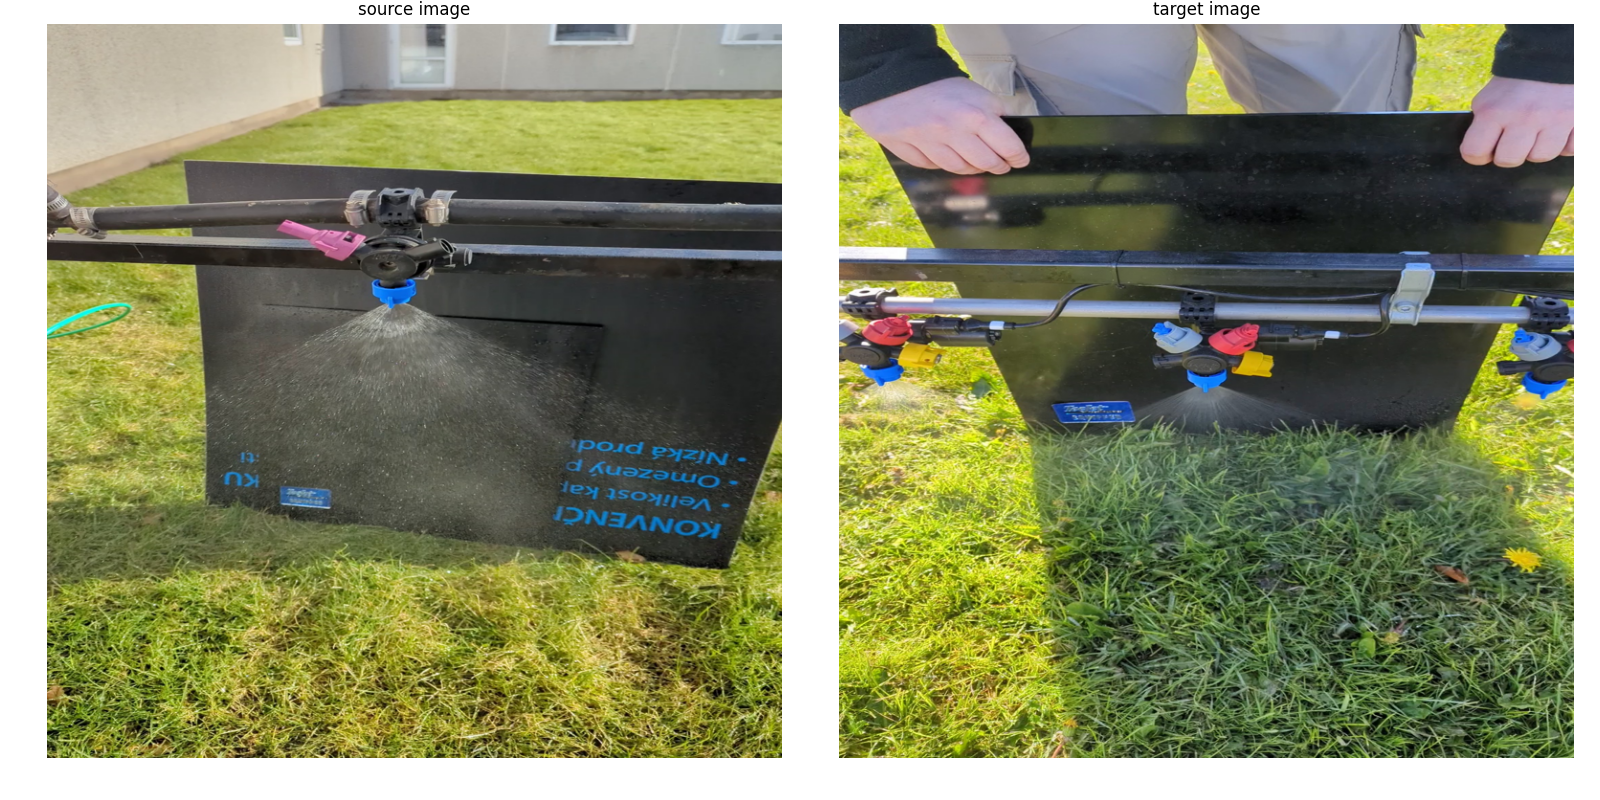

In [12]:
from src.utils.visualization import Demo
'''
left is source image, right is target image.
you can click on the source image, and DIFT will find the corresponding
point on the right image, mark it with red point and also plot the per-pixel 
cosine distance as heatmap.
'''
demo = Demo(imglist, ft, img_size)
demo.plot_img_pairs(fig_size=8)